In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import zipfile

from tqdm import tqdm

import cv2
from PIL import Image, ImageEnhance
from skimage.feature import hog
from skimage.segmentation import active_contour
from skimage import io as ski_io, color as ski_color, filters as ski_filters
from skimage.draw import ellipse_perimeter
from skimage.draw import ellipse



In [1]:
pip install kaggle

     ---------------------------------------- 0.0/82.7 kB ? eta -:--:--
     --------- ---------------------------- 20.5/82.7 kB 640.0 kB/s eta 0:00:01
     -------------------------------------- 82.7/82.7 kB 928.9 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105796 sha256=9a4d8b0073b28c1c73f4bd9b6bfd555a1d045e0bdf18caeab190f8dc33cf77ff
  Stored in directory: c:\users\bazoo\appdata\local\pip\cache\wheels\ff\55\fb\b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle
Note: you may need to restart the kernel to use updated packages.


In [3]:
!kaggle datasets download -d deathtrooper/multichannel-glaucoma-benchmark-dataset

Dataset URL: https://www.kaggle.com/datasets/deathtrooper/multichannel-glaucoma-benchmark-dataset
License(s): other




  0%|          | 0.00/2.93G [00:00<?, ?B/s]
  0%|          | 1.00M/2.93G [00:00<16:31, 3.17MB/s]
  0%|          | 3.00M/2.93G [00:00<08:09, 6.41MB/s]
  0%|          | 4.00M/2.93G [00:00<07:28, 7.00MB/s]
  0%|          | 5.00M/2.93G [00:00<06:52, 7.61MB/s]
  0%|          | 7.00M/2.93G [00:00<05:38, 9.27MB/s]
  0%|          | 9.00M/2.93G [00:01<05:09, 10.1MB/s]
  0%|          | 11.0M/2.93G [00:01<04:54, 10.6MB/s]
  0%|          | 13.0M/2.93G [00:01<04:43, 11.0MB/s]
  1%|          | 15.0M/2.93G [00:01<04:38, 11.2MB/s]
  1%|          | 17.0M/2.93G [00:01<04:33, 11.4MB/s]
  1%|          | 19.0M/2.93G [00:02<04:30, 11.5MB/s]
  1%|          | 21.0M/2.93G [00:02<04:30, 11.5MB/s]
  1%|          | 23.0M/2.93G [00:02<04:28, 11.6MB/s]
  1%|          | 25.0M/2.93G [00:02<04:26, 11.7MB/s]
  1%|          | 27.0M/2.93G [00:02<04:26, 11.7MB/s]
  1%|          | 29.0M/2.93G [00:02<04:25, 11.7MB/s]
  1%|1         | 31.0M/2.93G [00:03<04:24, 11.8MB/s]
  1%|1         | 33.0M/2.93G [00:03<04:30, 11.5MB/s]
 

In [11]:
with zipfile.ZipFile("multichannel-glaucoma-benchmark-dataset.zip",'r') as dataset:
    dataset.extractall()

# **Preprocessing**

0.   Cropping image
1.   Image Enhancement      
2.   Image Downscaling
3.   ROI Extraction
4.   Optic Disk Extraction


1. Image enhancement


In [2]:
# Image enhancement

def increase_sharpness(image, sharpness_factor):
    # Apply a Gaussian blur to the image
  blurred = cv2.GaussianBlur(image, (0, 0), sigmaX=3, sigmaY=3)

  sharpened = cv2.addWeighted(image, 1 + sharpness_factor, blurred, -sharpness_factor, 0)
  return sharpened

def increase_contrast(image, contrast_factor):
    # Convert the image to LAB color space
    B,G,R = cv2.split(image)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_red = clahe.apply(R)
    clahe_green = clahe.apply(G)
    clahe_blue = clahe.apply(B)
    
    contrast_img = cv2.merge([clahe_blue, clahe_green, clahe_red])
    return contrast_img
    
def de_noising(image):
  image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
  return image
    
def enhance_image(image, sharpness_factor, contrast_factor):
  #image = crop_square(image)
  image = increase_sharpness(image, sharpness_factor)
  image = increase_contrast(image, contrast_factor)
  image = de_noising(image)
  return image

2. Image downsizing

In [3]:
# Image Downsizing

# downsizing usign bilinear downsizing
def preprocess_downsizing(init_img_array, new_dim):
  init_height, init_width, _ = init_img_array.shape
  new_height = int(init_height * (new_dim / init_height))
  new_width = int(init_width * (new_dim / init_height))
  downsized = cv2.resize(init_img_array, (new_width, new_height))
  # downsized = cv2.copyMakeBorder(downsized, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])
  return downsized
    

3. ROI extraction

In [4]:
# Finding ROI
def score_ellipse(image_array, ellipse_center, axes_lengths, mean_brightness_image):
    mask = np.zeros_like(image_array, dtype=np.uint8)
    rr, cc = ellipse(ellipse_center[0], ellipse_center[1],
                     axes_lengths[0], axes_lengths[1], shape=image_array.shape)
    mask[rr, cc] = 1
    ellipse_region = image_array[mask == 1]
    
    mean_brightness_ellipse = (np.mean(ellipse_region)) / 255.0
    std_brightness = (np.std(ellipse_region)) / 255.0

    aspect_ratio = max(axes_lengths) / min(axes_lengths)
    aspect_ratio_score = 1 / aspect_ratio
    penalty = 0
    
    if aspect_ratio_score < 0.2:
        penalty = 0.2
    
    normalized_diff = (mean_brightness_ellipse - (mean_brightness_image / 255)) / (mean_brightness_ellipse + (mean_brightness_image / 255)) 
    
    score =  (0.5 * mean_brightness_ellipse) + (0.3 * std_brightness) + (0.3 * normalized_diff) + (0.1 * aspect_ratio_score) - penalty
    return score

def optic_disk_location(gray_blurred, window_size, step):
    window_size_y = window_size[0]
    window_size_x = window_size[1]
    step_y = step[0]
    step_x = step[1]
    best_score = 0
    image_height, image_width = gray_blurred.shape

    windows = []
    scores = []
    binary_thresh = []
    adaptive_thresh = []
    mean_brightness = np.mean(gray_blurred)
    for y in range(0, image_height - window_size_y, step_y):
        for x in range(0, image_width - window_size_x, step_x):
            #print(f"Processing window at ({y}, {x})")
            window = gray_blurred[y: (y + window_size_y), x: (x + window_size_x)]

            # find ellipse in the window and score each window
            (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(window)
            _, thresh = cv2.threshold(window, maxVal - 35, 255, cv2.THRESH_BINARY)
            binary_thresh.append(thresh)
            #adaptive thresh test:
            a_thresh = cv2.adaptiveThreshold(window, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
            adaptive_thresh.append(a_thresh)
            contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            
            if contours:
                largest_contour = max(contours, key=cv2.contourArea)
                if len(largest_contour) > 4:

                    ellipse = cv2.fitEllipse(largest_contour)
                    (x_center, y_center), (MA, ma), angle = ellipse
                    score = score_ellipse(window, (y_center, x_center), (MA,ma), mean_brightness)
                    _window = window.copy()
                    cv2.ellipse(_window, (int(x_center), int(y_center)), (int(MA // 2), int(ma // 2)), 0, 0, 360, (255, 0, 0), 2)
                    windows.append(_window)
                    scores.append(score)
                    #print(f"Score of window at ({y}, {x}): {score}")
                    #print(f"Elipse location {y + y_center}, {x + x_center}")
                    if score > best_score:
                        best_score = score
                        best_ellipse_location = (y + y_center, x + x_center)
                else:
                    scores.append(0)
    return best_ellipse_location
    """
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5)
    for i, ax in enumerate(axes.flat):
        if i < len(binary_thresh):
            ax.imshow(binary_thresh[i], cmap = 'gray')
            if i < len(scores):
                ax.set_title(f'Score: {scores[i]:.2f}')
            ax.axis('off')
        else:
            ax.axis('off')  # Hide any unused subplots
    
    plt.show()
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5)
    for i, ax in enumerate(axes.flat):
        if i < len(adaptive_thresh):
            ax.imshow(adaptive_thresh[i], cmap = 'gray')
            if i < len(scores):
                ax.set_title(f'Score: {scores[i]:.2f} ')
            ax.axis('off')
        else:
            ax.axis('off')  # Hide any unused subplots

    plt.show()
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5)
    for i, ax in enumerate(axes.flat):
        if i < len(windows):
            ax.imshow(windows[i], cmap = 'gray')
            if i < len(scores):
                ax.set_title(f'Score: {scores[i]:.2f}')
            ax.axis('off')
        else:
            ax.axis('off')  # Hide any unused subplots

    plt.show()
    print(best_ellipse_locations)
    best_ellipse_locations.sort(key = lambda x: x[0], reverse = True)
    print(best_ellipse_locations)
    return best_ellipse_locations
    """
def process_ROI(image_array, radius):
    gray = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)

    #converting to uint8 image
    #gray_normalized = (gray_normalized * 255).astype(np.uint8)
    # Apply a Gaussian blur to the image
    gray_blurred = cv2.GaussianBlur(gray, (11, 11), 0)

    image_height, image_width = gray_blurred.shape
    #print(f"image size {image_height}, {image_width}")
    # iteration window size: height/2 x width/2
    # iteration step:        height/4 and width/4
    window_size_y = int(image_height/2)
    window_size_x = int(image_width/2)
    step_y = int(image_height/4) - 1
    step_x = int(image_width/4) - 1

    best_ellipse_locations = optic_disk_location(gray_blurred, (window_size_y, window_size_x), (step_y, step_x))

    # adding radius sized padding to each sides.
    
    crop_rad = radius * 0.65
    image_array = cv2.copyMakeBorder(image_array, radius, radius, radius, radius, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    x_start = int( (best_ellipse_locations[1] + radius) - crop_rad)
    y_start = int( (best_ellipse_locations[0] + radius) - crop_rad)
    x_end = int( (best_ellipse_locations[1] + radius) + crop_rad)
    y_end = int( (best_ellipse_locations[0] + radius) + crop_rad)
    
    ROI = image_array[y_start:y_end, x_start:x_end]
    ROI = cv2.GaussianBlur(ROI, (3, 3), 0)
    return ROI


4. Optic Disk Segmentatino

In [5]:
def optic_disk_crop(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Sobel edge detection
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = cv2.magnitude(sobelx, sobely)
    gradient_magnitude = cv2.convertScaleAbs(gradient_magnitude)
    
    # Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Define functions for scoring
    def circularity_score(radius, contour):
        ideal_area = np.pi * (radius ** 2)
        ideal_perimeter = 2 * np.pi * radius
        contour_area = cv2.contourArea(contour)
        contour_perimeter = cv2.arcLength(contour, True)
        area_ratio = min(contour_area / ideal_area, ideal_area / contour_area)
        perimeter_ratio = min(contour_perimeter / ideal_perimeter, ideal_perimeter / contour_perimeter)
        return area_ratio * perimeter_ratio
    
    def edge_coverage_score(circle_center, radius, edge_image):
        cx, cy = circle_center
        mask = np.zeros_like(edge_image, dtype=np.uint8)
        cv2.circle(mask, (cx, cy), radius, 255, -1)
        edges_in_circle = cv2.bitwise_and(edge_image, edge_image, mask=mask)
        edge_coverage = np.sum(edges_in_circle > 0) / (np.pi * (radius ** 2))
        return edge_coverage
    
    def final_circle_score(radius, contour, circle_center, edge_image):
        circularity = circularity_score(radius, contour)
        edge_coverage = edge_coverage_score(circle_center, radius, edge_image)
        return circularity * edge_coverage
    
    dp = 1.3
    min_dist = 30
    param1 = 50
    param2 = 30
    min_radius = 50
    max_radius = 128
    # Hough Circle Transform parameters
    
    # Detect circles
    circles = cv2.HoughCircles(gradient_magnitude, cv2.HOUGH_GRADIENT, dp, min_dist, 
                               param1=param1, param2=param2, minRadius=min_radius, maxRadius=max_radius)
    
    # Select the best circle
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        best_circle = None
        highest_score = -1
    
        for (cx, cy, cr) in circles:
            mask = np.zeros_like(gray)
            cv2.circle(mask, (cx, cy), cr, 255, -1)
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            if contours:
                score = final_circle_score(cr, contours[0], (cx, cy), edges)
                if score > highest_score:
                    highest_score = score
                    best_circle = (cx, cy, cr)
    
        if best_circle:
            x, y, r = best_circle
            x_start, y_start = max(0, x - r-10), max(0, y - r-10)
            x_end, y_end = min(image.shape[1], x + r+10), min(image.shape[0], y + r)
            cropped_circle_image = image[y_start:y_end, x_start:x_end]
    
            return cropped_circle_image
        else:
            print("No suitable circles found based on combined scoring.")
    else:
        print("No circles were detected.")


In [6]:
def display_img(path):
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)

In [7]:
def preprocess_image(init_path, final_path, dim=512,
                     sharpness_factor = 1.0, contrast_factor = 1.5, ODC = False):
  radius = int(dim//4)
  if dim % 2 == 0:
    radius += 1

  img = cv2.imread(init_path)
  if img is None:
    print(f"Image {init_path} could not be loaded.")
    return
  img = preprocess_downsizing(img, dim)
  img_enhanced = enhance_image(img, sharpness_factor, contrast_factor)

  img = process_ROI(img_enhanced, radius)
  if ODC:
    img = optic_disk_crop(img)
  cv2.imwrite(final_path, img)
  return

In [ ]:
# process fundus-images in dataset
import glob
import os

fundus_image_dir = 'full-fundus/full-fundus'
roi_dir = 'full-fundus/full-fundus/processed_roi'


os.makedirs(roi_dir, exist_ok=True)

    
def get_files_starting_with(folder_path, prefix):
    
    # Construct the pattern to match files that start with the prefix
    pattern = os.path.join(folder_path, f"{prefix}*")
    
    # Use glob to find all matching files
    matching_files = glob.glob(pattern)
    
    return matching_files

# process images
# prefix - to process certain datasets in the dataset directory
def process_image(image_dir, out_dir, ext_curr, ext_new, res, prefix = ''):
  if len(prefix) > 0:
      files = get_files_starting_with(image_dir, prefix)
      files = [os.path.basename(x) for x in files]
  else: 
      files = os.listdir(image_dir)
  for filename in files:
    if filename.lower().endswith(ext_curr):
      img_path = os.path.join(image_dir, filename)
      out_path = os.path.join(out_dir, os.path.splitext(filename)[0] + ext_new)
      print(img_path)
      print(out_path)
      try:
        preprocess_image(img_path, out_path, res)
        print(f"processed {outpath}")
      except:
        pass


# calling process_image function
process_image(fundus_image_dir, roi_dir, '.png', '.tiff', 512, 'BEH')

full-fundus/full-fundus\BEH-1.png
full-fundus/full-fundus/processed_roi\BEH-1.tiff
preprocessing error at full-fundus/full-fundus\BEH-1.png
full-fundus/full-fundus\BEH-10.png
full-fundus/full-fundus/processed_roi\BEH-10.tiff
preprocessing error at full-fundus/full-fundus\BEH-10.png
full-fundus/full-fundus\BEH-100.png
full-fundus/full-fundus/processed_roi\BEH-100.tiff
preprocessing error at full-fundus/full-fundus\BEH-100.png
full-fundus/full-fundus\BEH-101.png
full-fundus/full-fundus/processed_roi\BEH-101.tiff
preprocessing error at full-fundus/full-fundus\BEH-101.png
full-fundus/full-fundus\BEH-102.png
full-fundus/full-fundus/processed_roi\BEH-102.tiff
preprocessing error at full-fundus/full-fundus\BEH-102.png
full-fundus/full-fundus\BEH-103.png
full-fundus/full-fundus/processed_roi\BEH-103.tiff
preprocessing error at full-fundus/full-fundus\BEH-103.png
full-fundus/full-fundus\BEH-104.png
full-fundus/full-fundus/processed_roi\BEH-104.tiff
preprocessing error at full-fundus/full-fundus

C:\Users\bazoo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\bazoo\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\bazoo\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\bazoo\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\bazoo\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


preprocessing error at full-fundus/full-fundus\BEH-115.png
full-fundus/full-fundus\BEH-116.png
full-fundus/full-fundus/processed_roi\BEH-116.tiff
preprocessing error at full-fundus/full-fundus\BEH-116.png
full-fundus/full-fundus\BEH-117.png
full-fundus/full-fundus/processed_roi\BEH-117.tiff
preprocessing error at full-fundus/full-fundus\BEH-117.png
full-fundus/full-fundus\BEH-118.png
full-fundus/full-fundus/processed_roi\BEH-118.tiff
preprocessing error at full-fundus/full-fundus\BEH-118.png
full-fundus/full-fundus\BEH-119.png
full-fundus/full-fundus/processed_roi\BEH-119.tiff
preprocessing error at full-fundus/full-fundus\BEH-119.png
full-fundus/full-fundus\BEH-12.png
full-fundus/full-fundus/processed_roi\BEH-12.tiff
preprocessing error at full-fundus/full-fundus\BEH-12.png
full-fundus/full-fundus\BEH-120.png
full-fundus/full-fundus/processed_roi\BEH-120.tiff
preprocessing error at full-fundus/full-fundus\BEH-120.png
full-fundus/full-fundus\BEH-121.png
full-fundus/full-fundus/processe

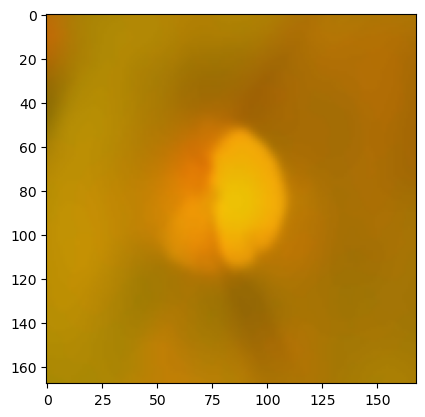

In [21]:
# single input test
#172F, 269F, 278F, 381S, 414F, 415F, 527S
#163S 172s 265S 269F 278F 328S 507S 503s 510s 541s 539s +2
# 245S 244F 248 249S 278F 269F 291fs 527f 544S 594S +2
initial_path = 'full-fundus/full-fundus\BEH-244.png'
final_path = 'temp/test_temp.tiff'
converted_test = preprocess_image(initial_path, final_path, 512)
display_img(final_path)